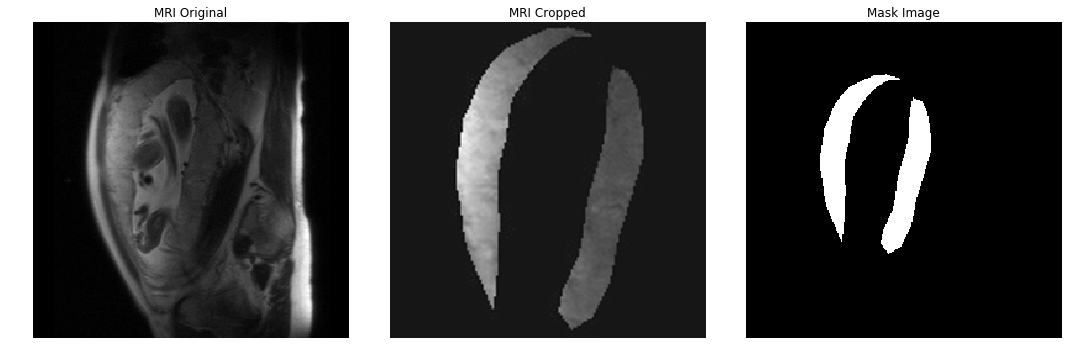

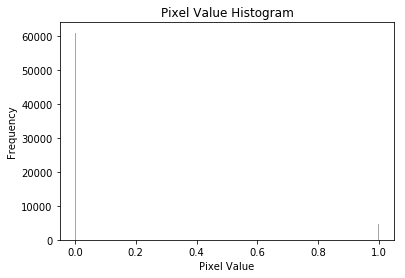

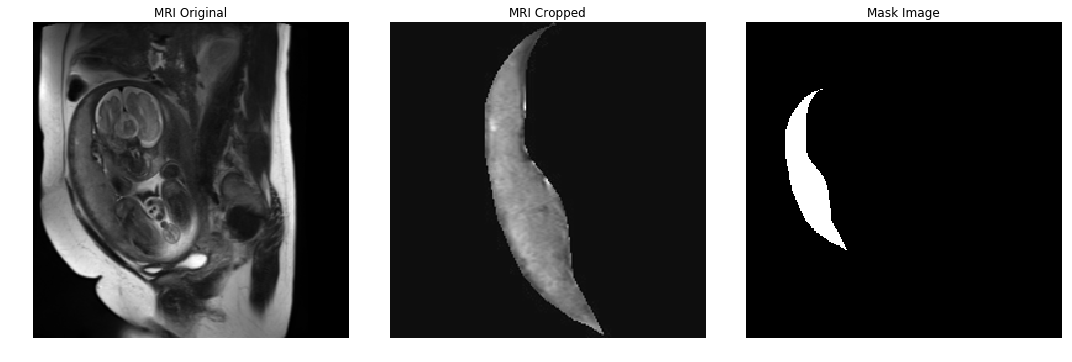

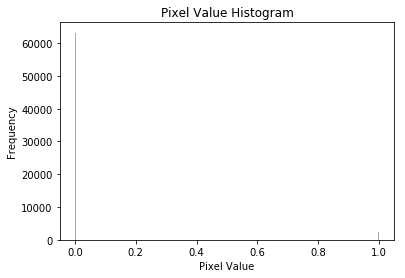

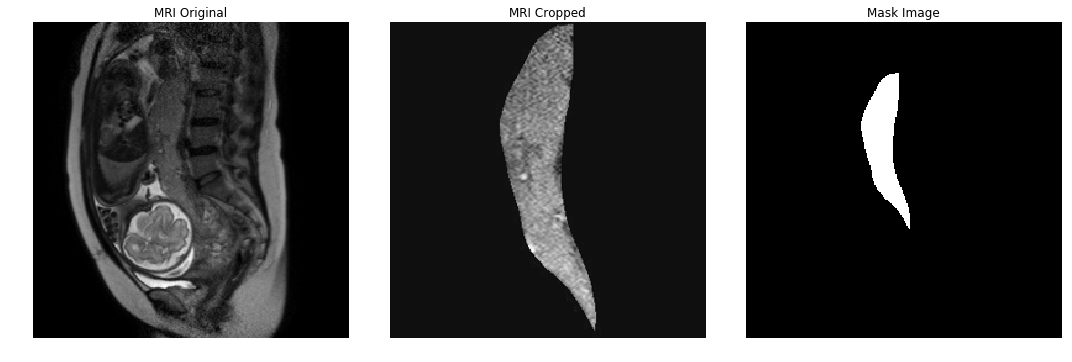

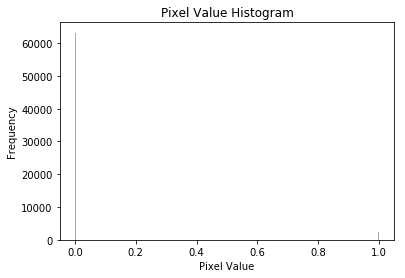

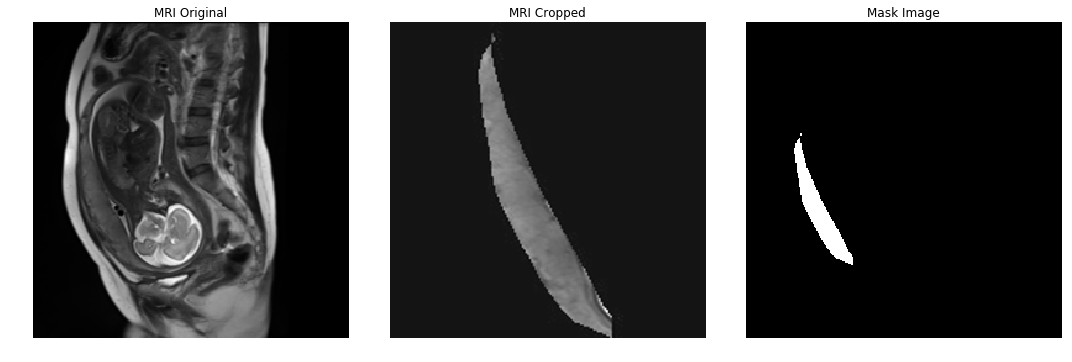

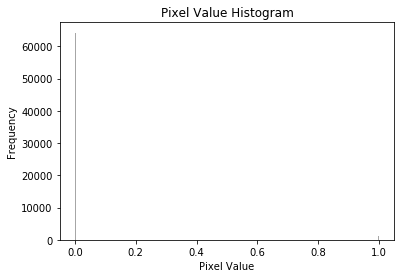

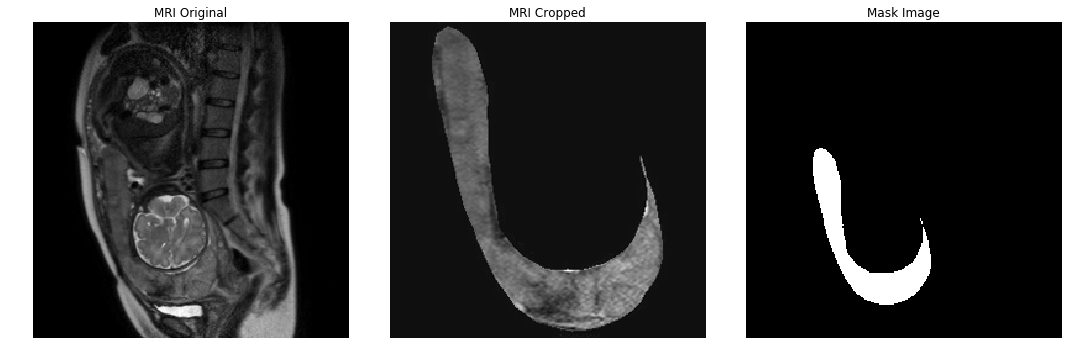

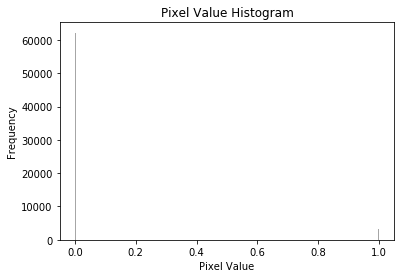

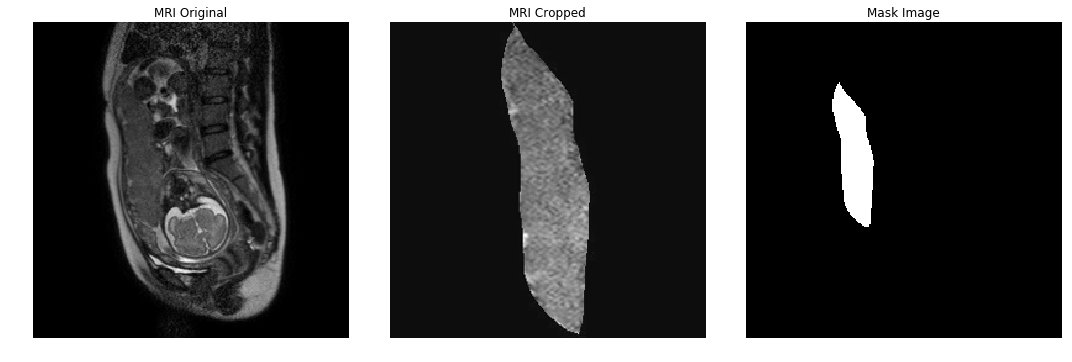

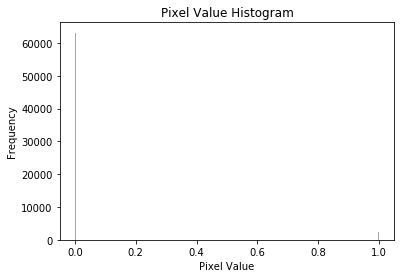

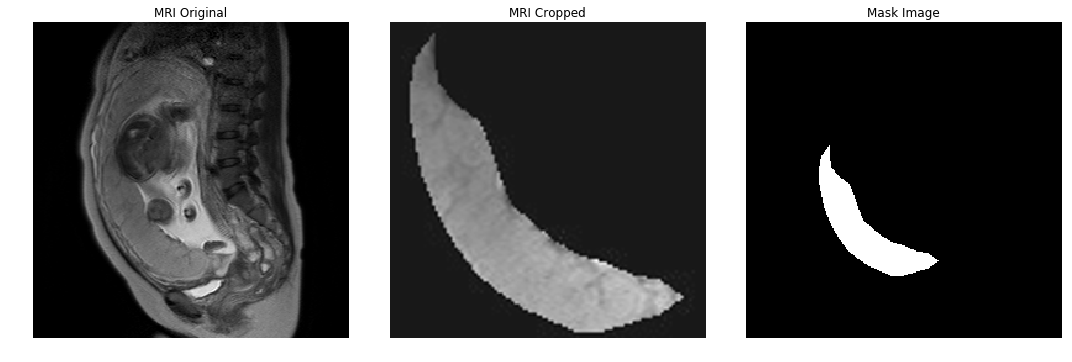

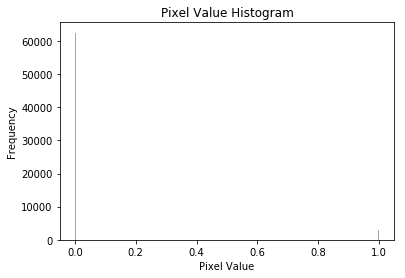

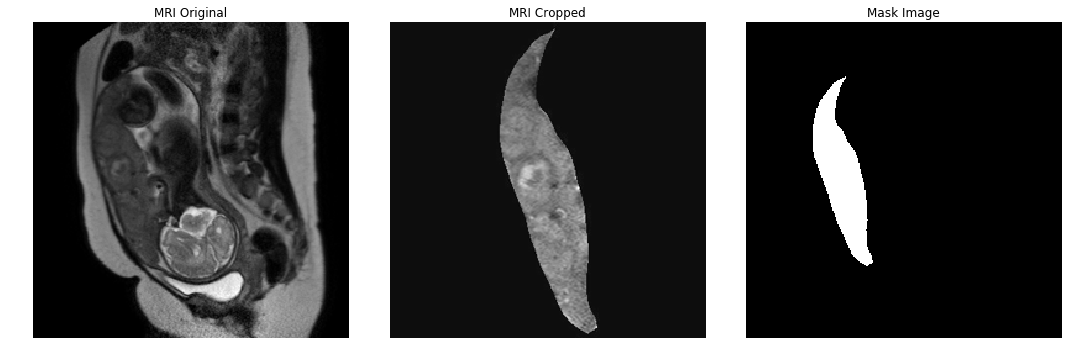

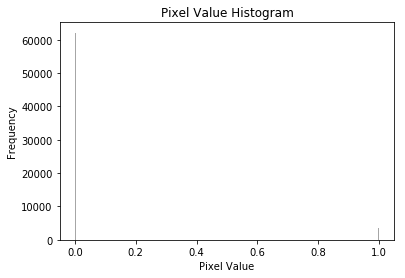

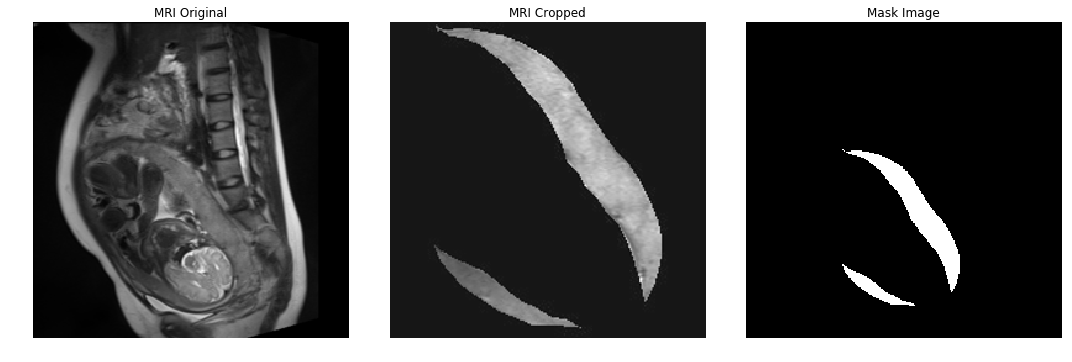

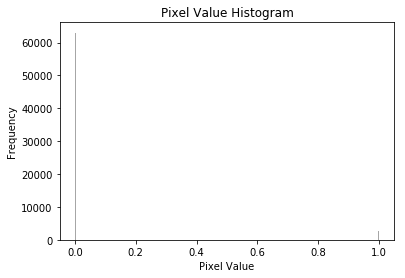

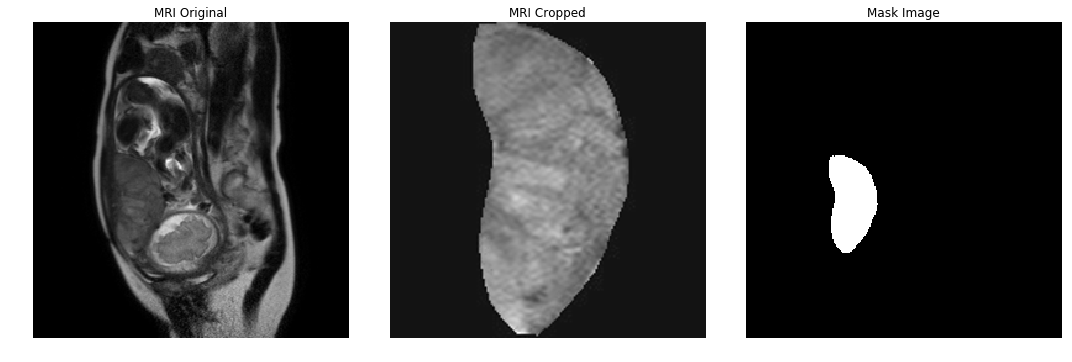

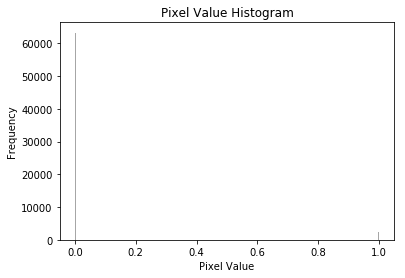

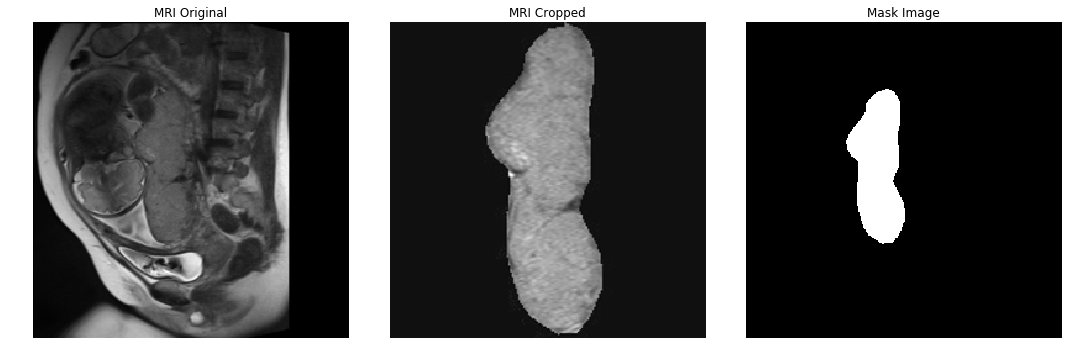

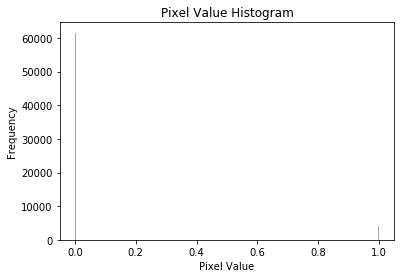

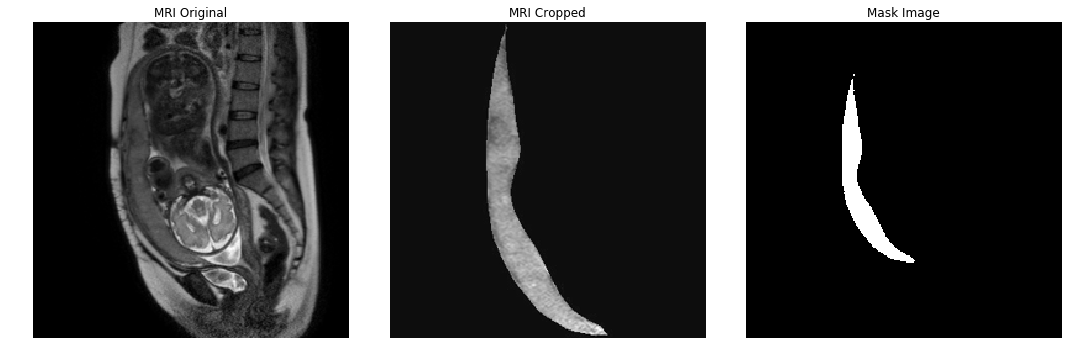

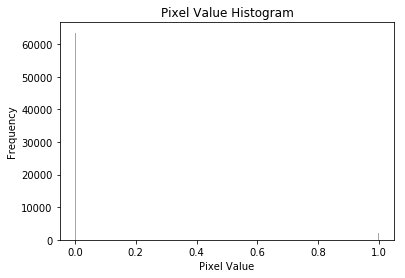

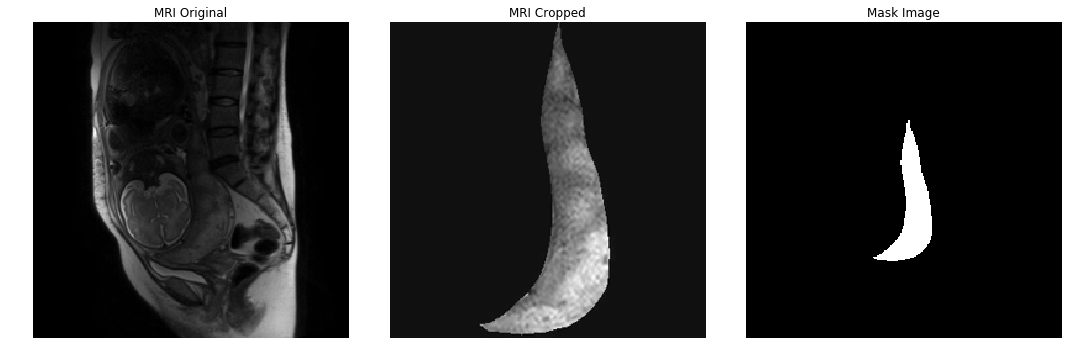

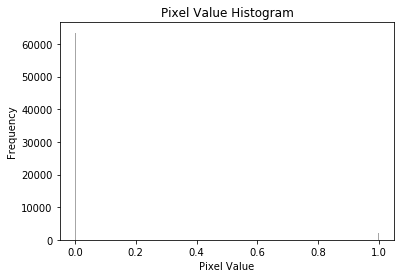

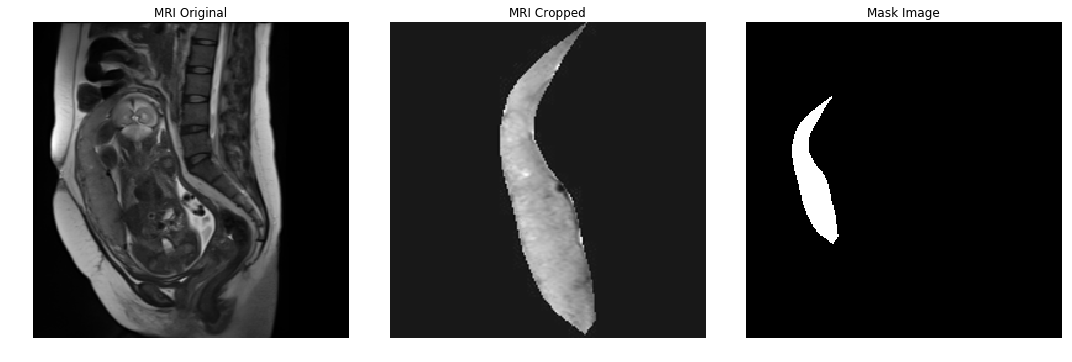

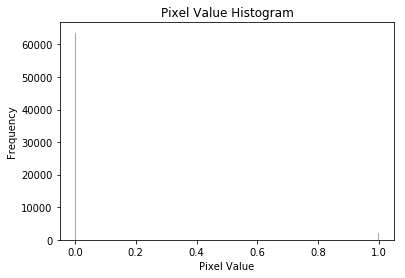

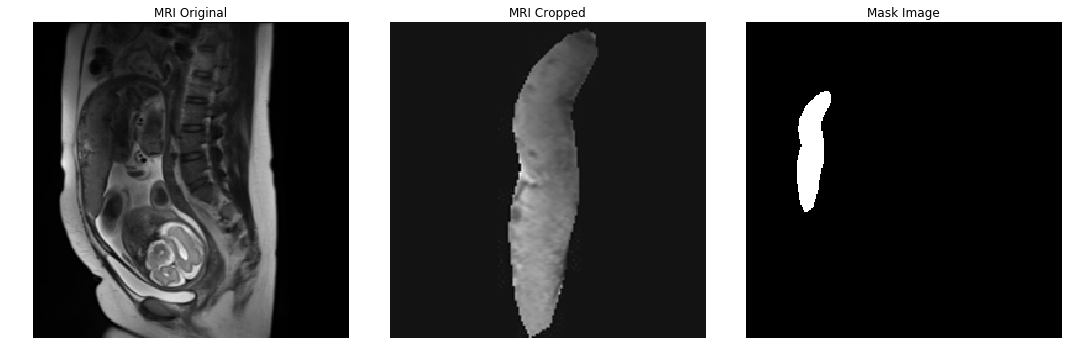

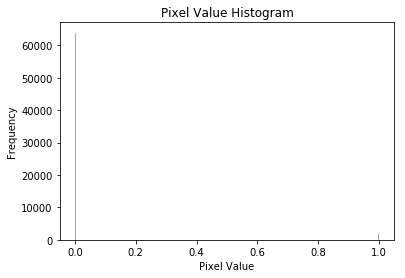

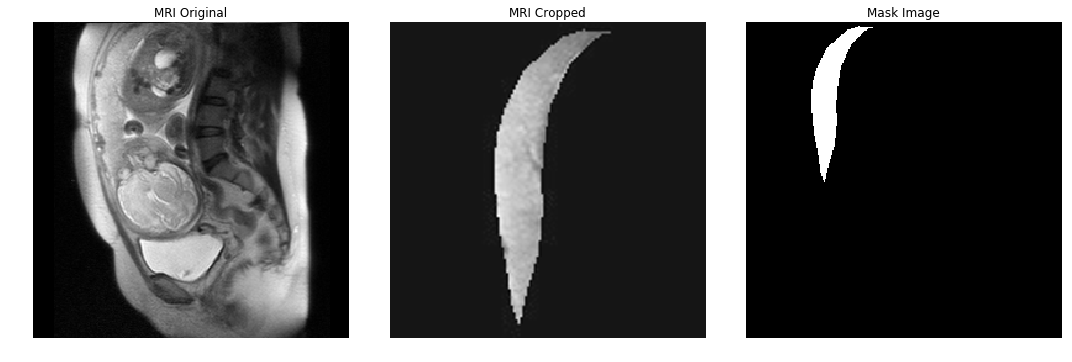

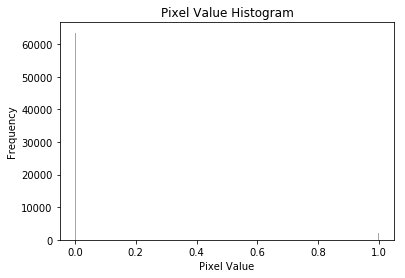

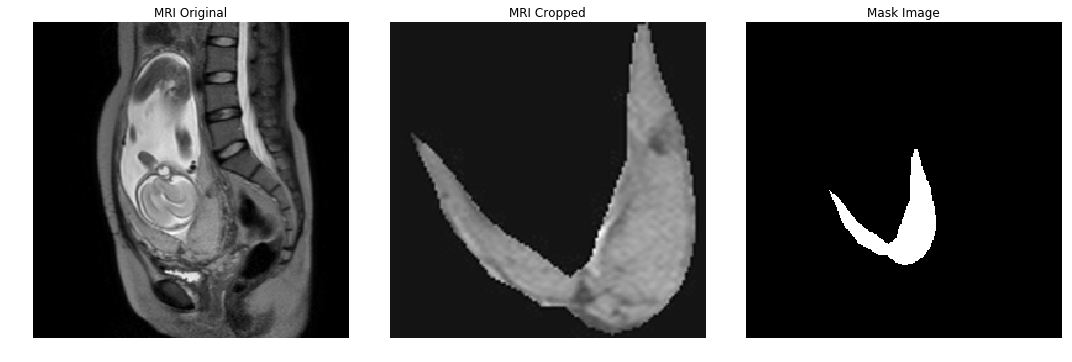

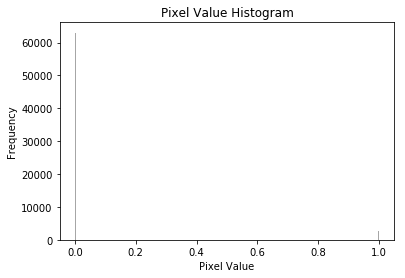

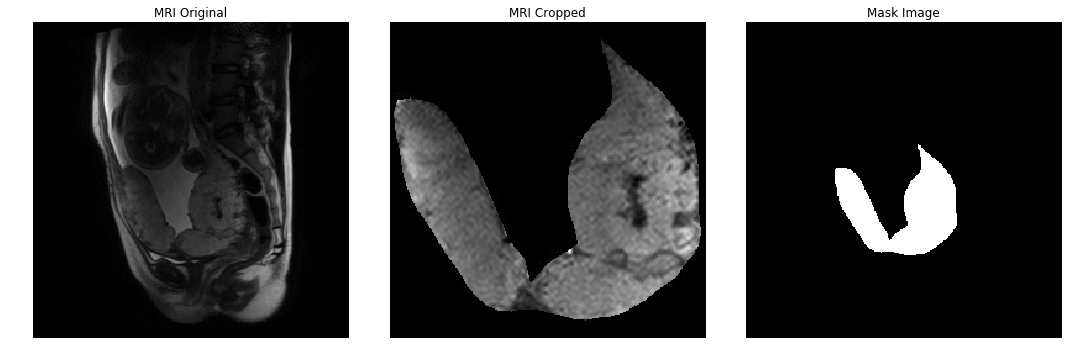

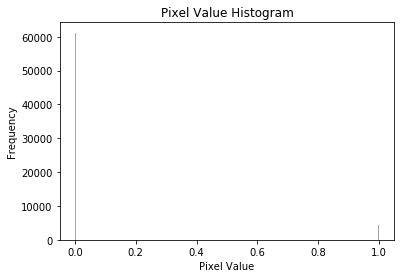

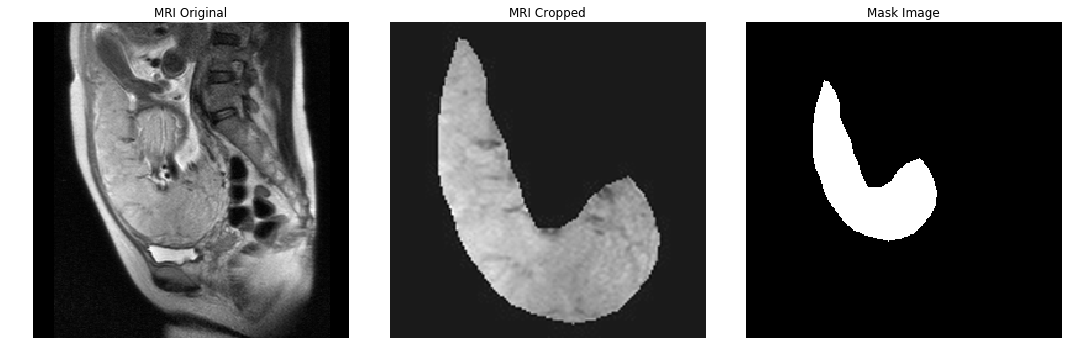

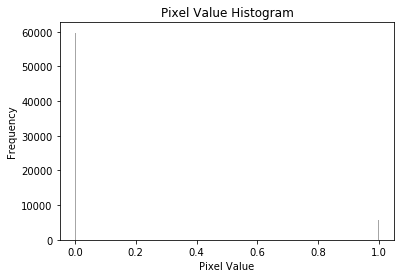

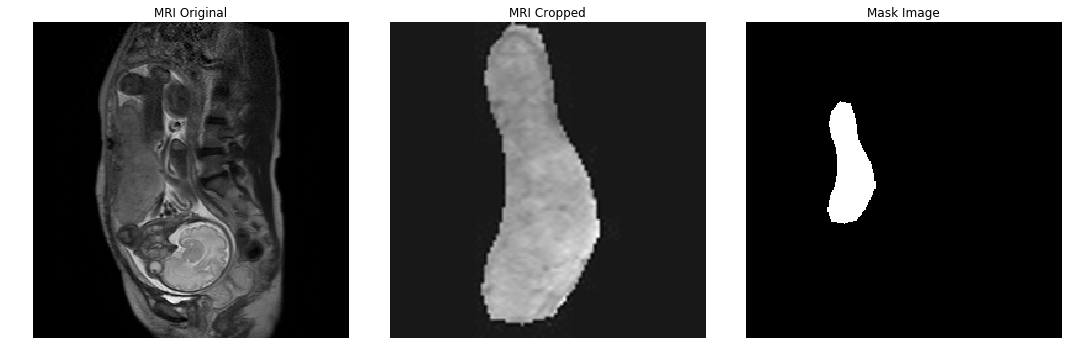

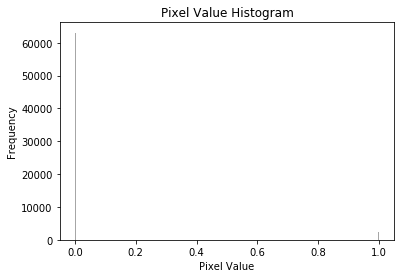

In [84]:
import torch
import matplotlib.pyplot as plt

data_train = torch.load('Data_tensor/f0_train')
for n in range(10*2):
    # 可視化
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1つ目の画像: MRIの生画像
    axes[0].imshow(data_train[n][0].squeeze(), cmap='gray')
    axes[0].set_title("MRI Original")
    axes[0].axis("off")

    # 2つ目の画像: MRIのクロップ画像
    axes[1].imshow(data_train[n][1].squeeze(), cmap='gray')
    axes[1].set_title("MRI Cropped")
    axes[1].axis("off")

    # 3つ目の画像: マスクの画像
    axes[2].imshow(data_train[n][2], cmap='gray')
    axes[2].set_title("Mask Image")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    # ヒストグラムを作成
    plt.hist(data_train[n][2].numpy().ravel(), bins=256, range=(0,1), color='gray', alpha=0.7)
    plt.title("Pixel Value Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()


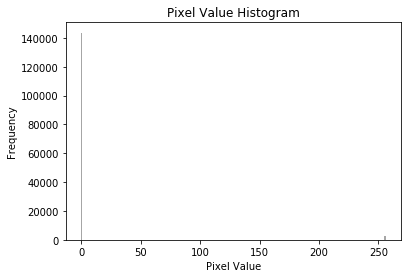

In [19]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
path_mask = 'Data_base/1005/1/data_mask.jpg'
mask = Image.open(path_mask)
mask = np.array(mask)


plt.hist(mask.ravel(), bins=256, range=(0,256), color='gray', alpha=0.7)
plt.title("Pixel Value Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [21]:
from torchvision import transforms
preprocess  = transforms.Compose([
    transforms.RandomResizedCrop((256, 256), scale=(1.0, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor()
])

mask = Image.fromarray(mask)
mask = preprocess(mask)
mask = torch.tensor(mask.clone().detach(), dtype=torch.int)
mask = torch.squeeze(mask)

/root/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


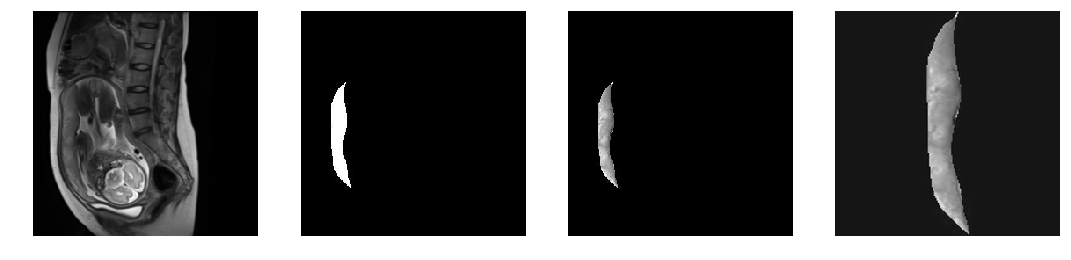

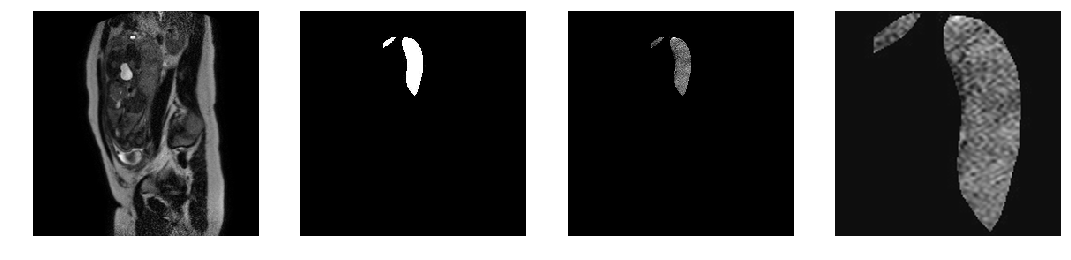

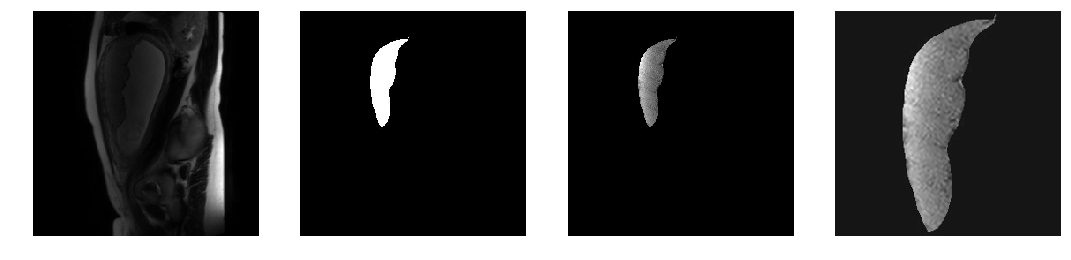

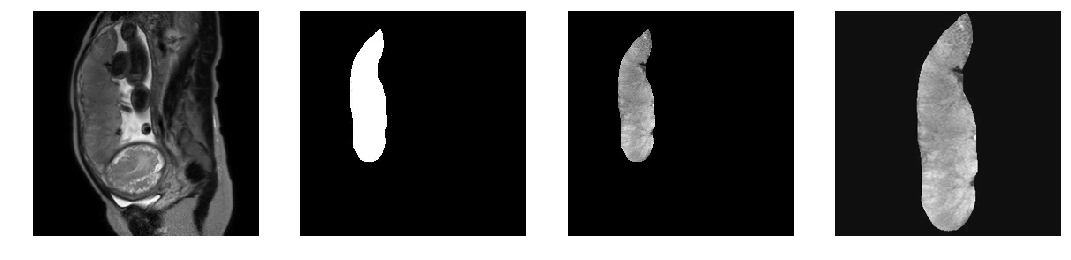

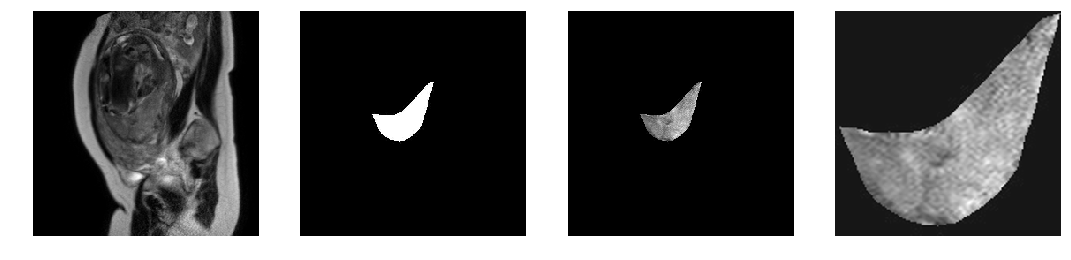

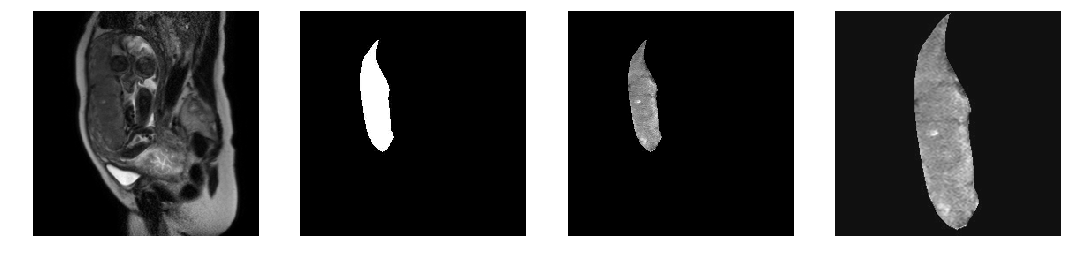

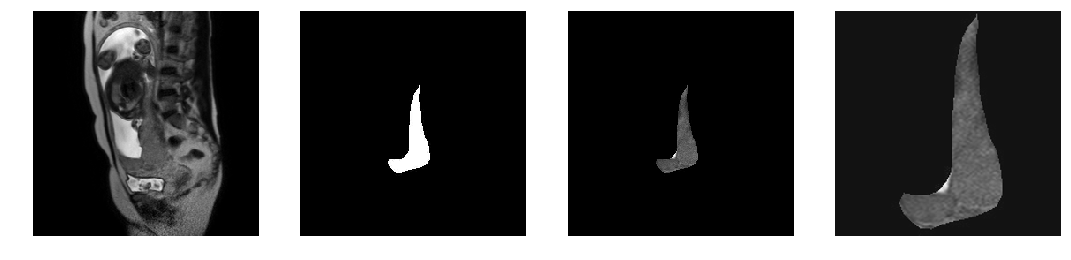

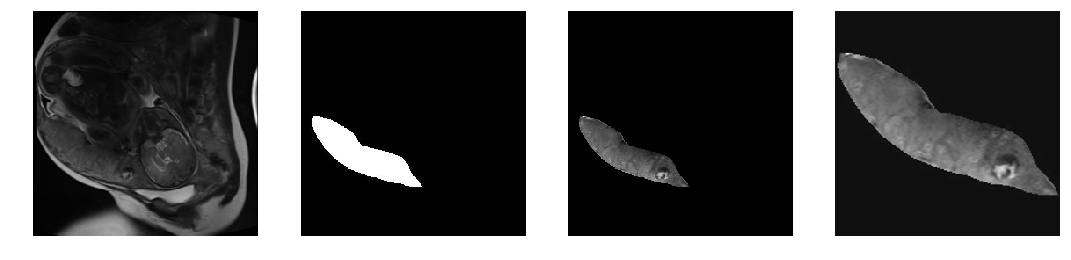

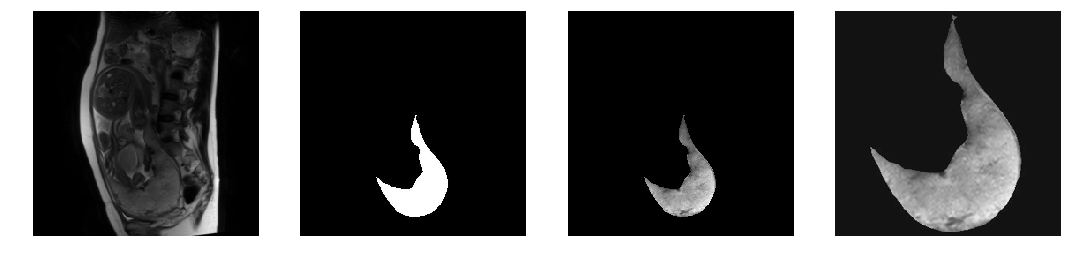

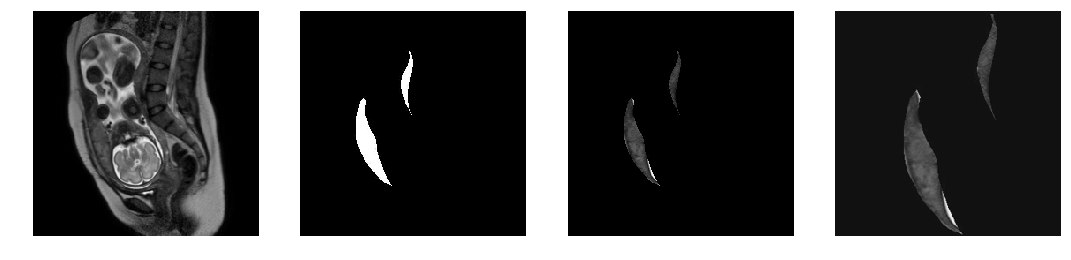

In [81]:
import os
import torch
import pydicom
import cv2
import matplotlib.pyplot as plt

from torchvision import transforms
preprocess  = transforms.Compose([
    transforms.RandomResizedCrop((256, 256), scale=(1.0, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor()
])

def mask_imgs(A, B): #A：img B:mask
    masked_A = A*B
    return masked_A

def crop_imgs(A, B): #A：img B:mask
    # maskから重心を計算
    nLabels, labelImages, D, center = cv2.connectedComponentsWithStats(B)
    D = D[1:]
    x = [d[0] for d in D]
    y = [d[1] for d in D]
    w = [d[2] for d in D]
    h = [d[3] for d in D]
    xmax = max([a + b for a, b in zip(x, w)])
    xmin = min(x)
    ymax = max([a + b for a, b in zip(y, h)])
    ymin = min(y)
    w = xmax - xmin
    h = ymax - ymin
    l = max([w,h])
    cropped_A = Image.fromarray(A).crop((xmin+w/2-l/2, ymin+h/2-l/2, xmin+w/2+l/2, ymin+h/2+l/2)).resize((256,256))
    cropped_A = np.array(cropped_A)
    return cropped_A


def list_folders(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

folders = list_folders('Data_base')
for n in range(10):
    stem = 'Data_base/'+folders[n]+'/0/'
    ###img
    path_dicom = stem + '/data_dicom.dcm'
    dicom = pydicom.dcmread(path_dicom)
    img   = dicom.pixel_array
    wc    = dicom.WindowCenter
    ww    = dicom.WindowWidth
    window_max = wc + ww/2                     
    window_min = wc - ww/2

    img   = 255*(img - window_min)/(window_max - window_min) 

    img[img > 255] = 255
    img[img < 0] = 0 
    ###

    ###mask
    path_mask = stem + '/data_mask.jpg'
    mask = Image.open(path_mask)
    mask = np.array(mask)
    m0 = mask
    ###

    ###cropped_img
    cimg = mask_imgs(img, mask)
    c0 = cimg
    cimg = crop_imgs(cimg, mask)
    c1 = cimg

    ###preprocessing
    img  = Image.fromarray(img)
    img  = preprocess(img)

    cimg = Image.fromarray(cimg)
    cimg = preprocess(cimg)

    mask = Image.fromarray(mask)
    mask = preprocess(mask)
#         mask = torch.tensor(mask.clone().detach(), dtype=torch.int)
    mask = torch.squeeze(mask)
    # 可視化
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(img.squeeze(), cmap='gray')
    axes[0].axis("off")
    axes[1].imshow(m0.squeeze(), cmap='gray')
    axes[1].axis("off")
    axes[2].imshow(c0.squeeze(), cmap='gray')
    axes[2].axis("off")
    axes[3].imshow(c1.squeeze(), cmap='gray')
    axes[3].axis("off")
    
    plt.tight_layout()
    plt.show()
